# Notebook 2: Reverse Geocoding (Zip Code to Lat/Long Mapping) 
### Team WestCoastBestCoast
Thomas Cycyota, Jasmine Fu, Sun Choi, Jeffrey Knapp, David Mosto

### Purpose
This notebook serves as the second step in pre-processing Zillow Challenge data, primarily focused on conducting 'reverse geocoding' or the process of determining a location's zipcode from its latitude and longitude coordinates.

## Step 1: Load Data
Import CLEANED Zillow housing dataset as Pandas Dataframe.

In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [9]:
data = pd.read_csv("properties_2016_cleanv3.csv")

In [10]:
data.sample(5)

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age
300975,304511,12374531,3.0,4.0,0.0,2204.0,6037.0,3.0,0.0,0.0,0,0,13.0,6585.0,246.0,3101.0,2.0,1.0,0,34018604.0,-118141594.0,62578.0,66.0
1578206,1596533,11855560,1.0,2.0,0.0,838.0,6037.0,1.0,0.0,0.0,0,0,7.0,5958.0,261.0,3101.0,1.0,1.0,0,34038082.0,-118119807.0,416000.0,66.0
652121,659779,11927109,1.0,3.0,0.0,1691.0,6037.0,1.0,0.0,0.0,0,0,7.0,9146.0,261.0,3101.0,1.0,1.0,0,34111958.0,-118067593.0,1725000.0,63.0
411430,416154,10914079,3.0,3.0,0.0,1480.0,6037.0,3.0,0.0,0.0,0,0,2.0,0.0,266.0,3101.0,1.0,1.0,0,34147600.0,-118422000.0,651000.0,8.0
2937424,2971368,14381707,2.0,4.0,8.0,1735.0,6059.0,2.0,2.0,483.0,0,0,13.0,8910.0,261.0,1286.0,1.0,1.0,0,33594377.0,-117685150.0,240250.0,46.0


In [11]:
data.fips.value_counts()

6037.0    1981948
6059.0     741468
6111.0     216417
Name: fips, dtype: int64

## Step 2: Map to Zip Code using Lat/Long
Because reverse geomapping (e.g. lat/long to Zipcode) is an expensive process, we'll do our best with locating the closest Zip code 'node' center from each lat/long point. 

Mapping Zip Code from Latitude/Longitude is actually quite an expensive process. For the millions of rows of data we have, estimates I saw ranged anywhere from several hundred to tens of thousands of dollars to get a zip code mapping for every data point.

With this discovery, I investigated if it would be possible to map Lat/Long to its CLOSEST zip code center. For Southern California, zip codes are incredibly dense with non-linear boundaries:
![Southern California Zip Codes](SoCalZips.png)

We developed a technique that finds the closest zip-code center to each of our property listings. This technique effectively takes a listings lat/long coordinates, then finds the zipcode center with the closest Euclidean (e.g. straight-line) distance to it. 

To develop this technique, the code below uses a publicly available dataest from "geonames.org". That dataset, which contains zipcode lat/long centers for the entire United States, was filtered outside of this code to only contain California zipcodes. 

In [12]:
#Load zip_centers file, an extract of California zipcodes from a much larger database
#Source: http://download.geonames.org/export/zip/ Filename: us.zip
zip_centers = pd.read_csv("CAreversegeocoding.txt", sep='\t')
zip_centers.head()

,Countrycode,postalcode,placename,state,statecode,county,countycode,community,communitycode,latitude,longitude,accuracy,Unnamed: 12
0,US,94501,Alameda,California,CA,Alameda,1,NaN,NaN,37.7706,-122.2648,4.0,NaN
1,US,94502,Alameda,California,CA,Alameda,1,NaN,NaN,37.7351,-122.2431,4.0,NaN
2,US,94536,Fremont,California,CA,Alameda,1,NaN,NaN,37.5605,-121.9999,4.0,NaN
3,US,94537,Fremont,California,CA,Alameda,1,NaN,NaN,37.6802,-121.9215,4.0,NaN
4,US,94538,Fremont,California,CA,Alameda,1,NaN,NaN,37.5308,-121.9712,4.0,NaN


Quickly plot all datapoints to confirm it "looks like" the state of California:

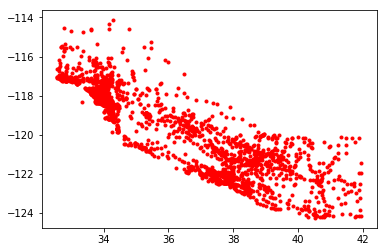

In [13]:
#Disaply outline of California in Zip Codes

plt.plot(zip_centers[['latitude']].values,zip_centers[['longitude']].values, 'r.')
plt.show()

In [14]:
latlongcenters = zip_centers[['latitude', 'longitude']].values
print(latlongcenters)

[[  37.7706 -122.2648]
 [  37.7351 -122.2431]
 [  37.5605 -121.9999]
 ...
 [  39.3459 -121.2663]
 [  39.4256 -121.3252]
 [  39.687  -121.045 ]]


Define a function that calculates the closest zip

In [18]:
#closest_zip function to find the closest euclidean-distance zip-code centroid from each listing 
def closest_zip(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

We can compare this `closest_zip` method with an open package for a few records: 

Python Package: https://geopy.readthedocs.io/en/1.10.0/
(install with `pip install geopy`)

In [19]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")
pattern = re.compile(r"^[0-9]{5}$")

In [20]:
#Testing on smallersubset
zip_test = data.sample(50)
match_count=0
# zip_test.head()
for index, row in zip_test.iterrows():
    latlong = str(round(row['latitude']*np.float_power(10,-6),6))+", "+str(round(row['longitude']*np.float_power(10,-6),6))
    print("Lat/Long: ",latlong)
    latlong_square = tuple(map(float, latlong.split(',')))
    pt_zip = closest_zip(latlong_square, latlongcenters)
    distance_zip = zip_centers.loc[pt_zip,'postalcode']
    print("closest_zip method: ", distance_zip)
    
    #Compare to Geopy method:
    location = geolocator.reverse(latlong)
    if "postcode" in location.raw['address'].keys():
        zipcode = location.raw['address']['postcode'][0:5]
        #Error handling for missing zipcode using Regex: exactly 5 numbers long
        if (pattern.match(zipcode)):
            final_zip = zipcode
    else:
        final_zip = "00000"
    print("geopy_method: ", final_zip)
    
    if str(final_zip)==str(distance_zip):
        match_count+=1

print("Of samples, found ", match_count, " matches!")
    

Lat/Long:  33.819877, -118.102373
closest_zip method:  90808
geopy_method:  90808
Lat/Long:  34.042681, -118.43693
closest_zip method:  90025
geopy_method:  90064
Lat/Long:  34.062917, -117.963461
closest_zip method:  91793
geopy_method:  91790
Lat/Long:  34.092799, -118.148185
closest_zip method:  91803
geopy_method:  91801
Lat/Long:  33.737556, -117.94312
closest_zip method:  92728
geopy_method:  92843
Lat/Long:  33.772726, -118.181143
closest_zip method:  90802
geopy_method:  90802
Lat/Long:  33.664, -117.979
closest_zip method:  92646
geopy_method:  92646
Lat/Long:  34.115113, -118.382782
closest_zip method:  90046
geopy_method:  90046
Lat/Long:  34.210853, -118.633804
closest_zip method:  91307
geopy_method:  91304
Lat/Long:  34.27841, -118.37775
closest_zip method:  91040


KeyboardInterrupt: 

After a few trials, we're not getting 100% accuracy (more like 60-70% exact mapping), but for our **FREE** purposes this is good enough, as we're at least getting neighboring zip codes (this is based on spot-checking I did for mismatched codes. 


Now lets use this technique on our entire dataset (this takes a while):

In [21]:
for index, row in data.iterrows():
    #Divide datapoint x10^-6
    latlong = str(round(row['latitude']*np.float_power(10,-6),6))+", "+str(round(row['longitude']*np.float_power(10,-6),6))
    #Convert to tuple for function
    latlong_square = tuple(map(float, latlong.split(',')))
#     print(latlong,latlong_square)
    #Find closest_zip using function, then use that index to lookup the postal code in mapping table
    pt_zip = closest_zip(latlong_square, latlongcenters)
#     print("pt_zip = ",pt_zip)
    result_zip = zip_centers.loc[pt_zip,'postalcode']
#     print("closest_zip= ", result_zip)
    #Write the results back to original 'data' DataFrame
    data.at[index,'zipcode_closest'] = result_zip
    if int(index)%100000==0:
        print("LOG: at row ", index)
    

LOG: at row  0
LOG: at row  100000
LOG: at row  200000
LOG: at row  300000
LOG: at row  400000
LOG: at row  500000
LOG: at row  600000
LOG: at row  700000
LOG: at row  800000
LOG: at row  900000
LOG: at row  1000000
LOG: at row  1100000
LOG: at row  1200000
LOG: at row  1300000
LOG: at row  1400000
LOG: at row  1500000
LOG: at row  1600000
LOG: at row  1700000
LOG: at row  1800000
LOG: at row  1900000
LOG: at row  2000000
LOG: at row  2100000
LOG: at row  2200000
LOG: at row  2300000
LOG: at row  2400000
LOG: at row  2500000
LOG: at row  2600000
LOG: at row  2700000
LOG: at row  2800000
LOG: at row  2900000


In [11]:
data.tail()

,Unnamed: 0,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age,zipcode_closest
2939828,2973774,6.0,8.0,0.0,4582.0,6037.0,6.0,0.0,0.0,0,0,13.0,0.0,246.0,3101.0,2.0,1.0,0,33879428.0,-118302589.0,800000.0,3.0,90247.0
2939829,2973775,1.0,2.0,0.0,798.0,6037.0,1.0,0.0,0.0,0,0,13.0,7034153.0,263.0,3101.0,1.0,1.0,0,34769356.0,-118553521.0,428749.0,9.0,93532.0
2939830,2973776,3.0,3.0,0.0,1526.0,6037.0,3.0,0.0,0.0,0,0,2.0,0.0,266.0,3101.0,1.0,1.0,0,34087735.0,-118063008.0,585100.0,1.0,91771.0
2939831,2973777,4.0,4.0,0.0,2110.0,6037.0,4.0,0.0,0.0,0,1,2.0,0.0,266.0,3101.0,1.0,1.0,1,33951985.0,-118124097.0,545688.0,1.0,90240.0
2939832,2973778,1.0,1.0,0.0,1040.0,6037.0,1.0,0.0,0.0,0,1,2.0,0.0,266.0,3101.0,1.0,1.0,0,34041100.0,-118234000.0,610967.0,105.0,90013.0


Count the number of listings that have been mapped to each zipcode.

In [171]:
data.zipcode_closest.value_counts()

93590.0    19276
93534.0    18011
93539.0    17593
93551.0    16576
92656.0    15541
93552.0    15227
91765.0    13865
90274.0    13478
92646.0    13222
92688.0    13009
91354.0    12921
92648.0    12854
91745.0    12508
91360.0    12489
92708.0    12447
92637.0    12226
90278.0    12055
92620.0    11992
90277.0    11991
91702.0    11891
90732.0    11449
92694.0    11448
93065.0    11214
90805.0    11193
91748.0    11104
93003.0    11086
92604.0    11056
90266.0    11048
92629.0    10874
90623.0    10769
           ...  
90014.0      729
93532.0      704
92865.0      689
92650.0      650
92676.0      629
93066.0      593
91199.0      537
93535.0      492
91008.0      476
93040.0      422
90012.0      335
92823.0      322
93001.0      291
91784.0      279
93009.0      255
90009.0      255
93544.0      240
93014.0      206
90058.0      198
93550.0      143
93560.0      133
92697.0      108
92397.0       89
93563.0       67
92372.0       49
93225.0       32
93243.0       32
93042.0       

In [176]:
data.shape

(2939833, 23)

In [24]:
data.sample(10)

,Unnamed: 0,parcelid,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age,zipcode_closest
446153,451402,11867461,1.0,2.0,0.0,1000.0,6037.0,1.0,0.0,0.0,0,0,7.0,4772.0,261.0,3101.0,1.0,1.0,0,34085524.0,-118155596.0,467000.0,68.0,91803.0
529923,536165,17206831,1.5,1.0,5.0,975.0,6111.0,1.0,2.0,0.0,0,0,13.0,0.0,266.0,2061.0,1.0,1.0,0,34294560.0,-118843429.0,216942.0,31.0,93021.0
685106,693104,12799019,1.0,2.0,0.0,1219.0,6037.0,1.0,0.0,0.0,0,0,7.0,4795.0,261.0,3101.0,1.0,1.0,0,33963796.0,-118034195.0,218339.0,69.0,90602.0
419705,424605,12591800,2.0,4.0,0.0,1682.0,6037.0,2.0,0.0,0.0,0,0,13.0,9003.0,246.0,3101.0,2.0,1.0,0,33829972.0,-118299028.0,358612.0,54.0,90502.0
451459,456710,13909721,1.0,2.0,0.0,1158.0,6059.0,1.0,1.0,240.0,0,0,13.0,6654.0,261.0,1286.0,1.0,1.0,0,33859661.0,-117971140.0,160715.0,67.0,92837.0
2831667,2864423,13002498,2.0,3.0,0.0,2127.0,6037.0,2.0,0.0,0.0,0,0,13.0,9815.0,261.0,3101.0,1.0,1.0,0,34070281.0,-118035430.0,408127.0,105.0,91734.0
997886,1009409,14621598,3.0,3.0,6.0,1663.0,6059.0,3.0,0.0,0.0,0,0,24.0,0.0,266.0,1286.0,1.0,1.0,0,33620700.0,-117720000.0,261170.0,46.0,92637.0
2502795,2531810,11552427,1.0,3.0,0.0,1129.0,6037.0,1.0,0.0,0.0,0,0,7.0,5700.0,261.0,3101.0,1.0,1.0,0,34014069.0,-118442954.0,741077.0,65.0,90066.0
1636330,1655348,11620799,3.0,2.0,0.0,1452.0,6037.0,3.0,0.0,0.0,0,0,2.0,20282.0,266.0,3101.0,1.0,1.0,0,34059100.0,-118425000.0,520455.0,27.0,90067.0
2566488,2596195,12848296,3.0,3.0,0.0,2370.0,6037.0,3.0,0.0,0.0,0,0,2.0,7595.0,261.0,3101.0,1.0,1.0,0,33974772.0,-117885428.0,413311.0,20.0,91748.0


Only select certain columns to save, then save off as a CSV:

In [23]:
save_cols = ['parcelid','bathroomcnt', 'bedroomcnt', 'roomcnt','calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'heatingorsystemtypeid','lotsizesquarefeet', 'propertylandusetypeid', 'regionidcounty',
       'unitcnt', 'numberofstories', 'taxdelinquencyflag', 'taxvaluedollarcnt', 'age', 'zipcode_closest','latitude','longitude']

data.to_csv('properties_2016_cleanmappedv3.csv', index=False, columns=save_cols)

# Archive: Other Reverse Geomapping techniques tested.

Python Package: https://geopy.readthedocs.io/en/1.10.0/


(install with `pip install geopy`)

In [58]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")
pattern = re.compile(r"^[0-9]{5}$")

Below is a very long-running script to map all rows of data to their zipcode. Do not execute unless you're prepared to sit around. Zipcodes or Lat/Longs that cannot be found are filled in with `00000`, which will be dropped afterwards.

In [71]:
data.zipcode.value_counts()

00000    1213
Name: zipcode, dtype: int64

In [72]:
for index, row in zip_test.iterrows():
    latlong = str(round(row['latitude']*np.float_power(10,-6),6))+", "+str(round(row['longitude']*np.float_power(10,-6),6))
    location = geolocator.reverse(latlong)
    if "postcode" in location.raw.keys():
        zipcode = location.raw['address']['postcode'][0:5]
        #Error handling for missing zipcode using Regex: exactly 5 numbers long
        if (pattern.match(zipcode)):
            final_zip = zipcode
    else:
        final_zip = "00000"
#     print(final_zip)
    zip_test.at[index,'zipcode'] = final_zip
    

GeocoderQuotaExceeded: HTTP Error 429: Too Many Requests

In [63]:
data.head()

,Unnamed: 0,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age,zipcode
0,1,0.0,0.0,0.0,1800.0,6037.0,2.0,0.0,0.0,0,0,13.0,4083.0,261.0,3101.0,1.0,1.0,0,34140430.0,-118625364.0,27516.0,51.0,91302
1,2,0.0,0.0,0.0,73026.0,6037.0,2.0,0.0,0.0,0,0,13.0,63085.0,47.0,3101.0,2.0,1.0,0,33989359.0,-118394633.0,1413387.0,51.0,90230
2,3,0.0,0.0,0.0,5068.0,6037.0,2.0,0.0,0.0,0,0,13.0,7521.0,47.0,3101.0,1.0,1.0,0,34148863.0,-118437206.0,1156834.0,67.0,91423
3,4,0.0,0.0,0.0,1776.0,6037.0,2.0,0.0,0.0,0,0,13.0,8512.0,31.0,3101.0,1.0,1.0,0,34194168.0,-118385816.0,433491.0,68.0,91605
4,5,0.0,0.0,0.0,2400.0,6037.0,2.0,0.0,0.0,0,0,13.0,2500.0,31.0,3101.0,1.0,1.0,0,34171873.0,-118380906.0,283315.0,72.0,91601


## ARCHIVE: Testing Dev Code

In [11]:
lat = 33879276.0e-6
long = -118038747.0e-6
print(lat,",",long)

33.879276 , -118.038747


### geonames Manual Download
http://download.geonames.org/export/zip/

Test Points:
33707318.0	-117869217.0	92707
33954955.0	-118083555.0	90670
34229150.0	-118397893.0	91352
34190151.0	-118495671.0	91406
33734108.0	-117948315.0	92683

In [97]:
zip_centers = pd.read_csv("CAreversegeocoding.txt", sep='\t')
zip_centers.head()
latlongcenters = zip_centers[['latitude', 'longitude']].values
#Disaply outline of California in Zip Codes
import matplotlib.pyplot as plt
plt.plot(zip_centers[['latitude']].values,zip_centers[['longitude']].values, 'r.')
plt.show()

,Countrycode,postalcode,placename,state,statecode,county,countycode,community,communitycode,latitude,longitude,accuracy,Unnamed: 12
0,US,94501,Alameda,California,CA,Alameda,1,NaN,NaN,37.7706,-122.2648,4.0,NaN
1,US,94502,Alameda,California,CA,Alameda,1,NaN,NaN,37.7351,-122.2431,4.0,NaN
2,US,94536,Fremont,California,CA,Alameda,1,NaN,NaN,37.5605,-121.9999,4.0,NaN
3,US,94537,Fremont,California,CA,Alameda,1,NaN,NaN,37.6802,-121.9215,4.0,NaN
4,US,94538,Fremont,California,CA,Alameda,1,NaN,NaN,37.5308,-121.9712,4.0,NaN


In [79]:
latlongcenters = zip_centers[['latitude', 'longitude']].values

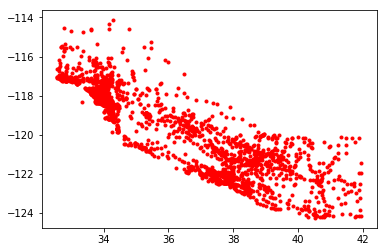

In [105]:
#Disaply outline of California in Zip Codes
import matplotlib.pyplot as plt
plt.plot(zip_centers[['latitude']].values,zip_centers[['longitude']].values, 'r.')
plt.show()

In [80]:
def closest_zip(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

In [111]:
test_pt = [37.778261, -122.514036]
test_pt_zip = closest_zip(test_pt, latlongcenters)
print(test_pt_zip)
zip_centers.loc[test_pt_zip,]

1943


Countrycode                                    US
postalcode                                  94121
placename                           San Francisco
state                                  California
statecode                                      CA
county           City and County of San Francisco
countycode                                     75
community                                     NaN
communitycode                                 NaN
latitude                                  37.7786
longitude                                -122.489
accuracy                                        4
Unnamed: 12                                   NaN
Name: 1943, dtype: object

In [96]:
zip_centers.loc[test_pt_zip,]

Countrycode                                    US
postalcode                                  94121
placename                           San Francisco
state                                  California
statecode                                      CA
county           City and County of San Francisco
countycode                                     75
community                                     NaN
communitycode                                 NaN
latitude                                  37.7786
longitude                                -122.489
accuracy                                        4
Unnamed: 12                                   NaN
Name: 1943, dtype: object

### reverse-geocoder Testing

In [75]:
import reverse_geocoder as rg

coordinates = (51.5214588,-0.1729636),(9.936033, 76.259952),(37.38605,-122.08385)

results = rg.search(coordinates,verbose=True) # default mode = 2
results



[OrderedDict([('lat', '51.51116'),
              ('lon', '-0.18426'),
              ('name', 'Bayswater'),
              ('admin1', 'England'),
              ('admin2', 'Greater London'),
              ('cc', 'GB')]),
 OrderedDict([('lat', '9.93988'),
              ('lon', '76.26022'),
              ('name', 'Cochin'),
              ('admin1', 'Kerala'),
              ('admin2', 'Ernakulam'),
              ('cc', 'IN')]),
 OrderedDict([('lat', '37.38605'),
              ('lon', '-122.08385'),
              ('name', 'Mountain View'),
              ('admin1', 'California'),
              ('admin2', 'Santa Clara County'),
              ('cc', 'US')])]

### Geopy Testing

In [27]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my-application")
location = geolocator.reverse("33.879276, -118.038747")
print(location.raw)


{'place_id': 204879851, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 13410843, 'lat': '33.8794277142857', 'lon': '-118.038756183673', 'display_name': '13780, Kyle Drive, Cerritos, Los Angeles County, California, 90703, USA', 'address': {'house_number': '13780', 'road': 'Kyle Drive', 'city': 'Cerritos', 'county': 'Los Angeles County', 'state': 'California', 'postcode': '90703', 'country': 'USA', 'country_code': 'us'}, 'boundingbox': ['33.879327714286', '33.879527714286', '-118.03885618367', '-118.03865618367']}


In [31]:
location.raw['address']['postcode']

'90703'

In [16]:
zip_test = data.sample(50)
zip_test.head()

,Unnamed: 0,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age
1280103,1294992,2.0,3.0,7.0,1959.0,6111.0,2.0,2.0,624.0,0,1,13.0,9398.0,261.0,2061.0,1.0,1.0,0,34183318.0,-118935517.0,347473.0,35.0
2748427,2780170,3.0,3.0,0.0,1710.0,6037.0,3.0,0.0,0.0,0,0,2.0,0.0,266.0,3101.0,1.0,1.0,0,33832381.0,-118314155.0,324234.0,5.0
2773401,2805482,3.0,4.0,0.0,2252.0,6037.0,3.0,0.0,0.0,0,1,2.0,12503.0,261.0,3101.0,1.0,1.0,0,33997697.0,-117809659.0,289944.0,41.0
1675146,1694513,3.0,4.0,0.0,2513.0,6037.0,3.0,0.0,0.0,0,0,2.0,5968.0,269.0,3101.0,1.0,1.0,0,34277043.0,-118582188.0,572286.0,13.0
932287,943158,2.0,2.0,0.0,2139.0,6037.0,2.0,0.0,0.0,0,0,7.0,8614.0,261.0,3101.0,1.0,1.0,0,34135231.0,-118058243.0,323085.0,74.0


In [55]:
pattern = re.compile(r"^[0-9]{5}$")
for index, row in zip_test.iterrows():
    latlong = str(round(row['latitude']*np.float_power(10,-6),6))+", "+str(round(row['longitude']*np.float_power(10,-6),6))
    location = geolocator.reverse(latlong)
    zipcode = location.raw['address']['postcode'][0:5]
    #Error handling for missing zipcode using Regex: exactly 5 numbers long
    if (pattern.match(zipcode)):
        final_zip = zipcode
    else:
        final_zip = "00000"
    zip_test.at[index,'zipcode'] = final_zip
    
    

In [57]:
zip_test.tail()

,Unnamed: 0,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,fips,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,poolcnt,heatingorsystemtypeid,lotsizesquarefeet,propertylandusetypeid,regionidcounty,unitcnt,numberofstories,taxdelinquencyflag,latitude,longitude,taxvaluedollarcnt,age,zipcode
939073,949944,1.0,2.0,5.0,812.0,6059.0,1.0,2.0,0.0,0,0,13.0,0.0,266.0,1286.0,1.0,1.0,0,33707318.0,-117869217.0,182150.0,43.0,92707
1405341,1421611,2.0,2.0,0.0,979.0,6037.0,2.0,0.0,0.0,0,0,7.0,7700.0,261.0,3101.0,1.0,1.0,0,33954955.0,-118083555.0,319799.0,65.0,90670
1472463,1489600,2.0,3.0,0.0,944.0,6037.0,2.0,0.0,0.0,0,0,7.0,5097.0,261.0,3101.0,1.0,1.0,0,34229150.0,-118397893.0,261274.0,68.0,91352
648365,656023,2.0,4.0,0.0,2103.0,6037.0,2.0,0.0,0.0,0,0,2.0,7249.0,261.0,3101.0,1.0,1.0,0,34190151.0,-118495671.0,94202.0,51.0,91406
2215845,2241530,2.0,4.0,7.0,2104.0,6059.0,2.0,2.0,452.0,0,0,6.0,6300.0,261.0,1286.0,1.0,2.0,0,33734108.0,-117948315.0,632000.0,51.0,92683
